In [42]:
import pandas as pd
from yome import Session
from yome.models import *
from yome.util import to_df, report
from yome.constants import colors
import re
from sqlalchemy import or_, and_
from sqlalchemy.orm import aliased
import seaborn as sns
from Bio import SeqIO
import numpy as np
from tqdm import tqdm
import scipy.stats

In [2]:
from mpl_recipes import mpl_setup
%mpl_setup

Populating the interactive namespace from numpy and matplotlib


In [3]:
session = Session()

In [26]:
sns.set_style('ticks')

In [4]:
# get y-ome list
yome = to_df(
    session.query(
        Gene.locus_id,
        KnowledgebaseGene.annotation_quality
    )
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .filter(Knowledgebase.name == 'Y-ome')
)

In [6]:
def _get_qual(feat, name, get_first=False):
    """Get a non-null attribute from the feature."""
    try:
        qual = feat.qualifiers[name]
    except KeyError:
        if get_first:
            return None
        else:
            return []

    def nonempty_str(s):
        s = s.strip()
        return None if s == '' else s

    if get_first:
        return nonempty_str(qual[0])
    else:
        return [y for y in (nonempty_str(x) for x in qual)
                if y is not None]

In [10]:
# Load genbank file
gb_file = SeqIO.read('../data/NC_000913.3.gb', 'gb')
locs = {}
for feature in gb_file.features:
    # only read in CDSs
    if feature.type != 'CDS':
        continue

    locus_tag = _get_qual(feature, 'locus_tag', True)
    locs[locus_tag] = int(feature.location.start)

In [24]:
starts = yome.merge(pd.DataFrame({'locus_id': k, 'start': v} for k, v in locs.items()))

In [ ]:
# based on https://stackoverflow.com/questions/28839246/scipy-gaussian-kde-and-circular-data

def vonmises_pdf(x, mu, kappa):
    return np.exp(kappa * np.cos(x - mu)) / (2. * np.pi * scipy.special.i0(kappa))

def vonmises_fft_kde(data, kappa, n_bins):
    bins = np.linspace(-np.pi, np.pi, n_bins + 1, endpoint=True)
    hist_n, bin_edges = np.histogram(data, bins=bins)
    bin_centers = np.mean([bin_edges[1:], bin_edges[:-1]], axis=0)
    kernel = vonmises_pdf(
        x=bin_centers,
        mu=0,
        kappa=kappa
    )
    kde = np.fft.fftshift(np.fft.irfft(np.fft.rfft(kernel) * np.fft.rfft(hist_n)))
    kde /= np.trapz(kde, x=bin_centers)
    return bin_centers, kde

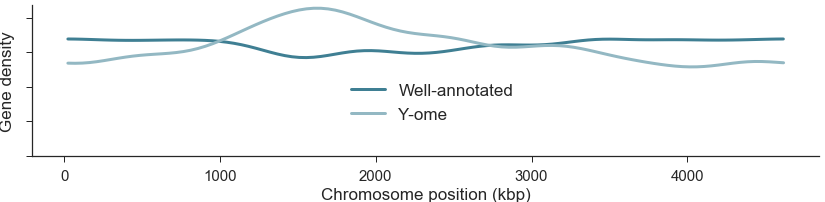

In [145]:
fig, ax = plt.subplots(figsize=(12,3))
fig.tight_layout()
for ann, label, color in [('high', 'Well-annotated', 'dark blue green'), ('low', 'Y-ome', 'light blue green')]:
    data = starts[starts.annotation_quality == ann].loc[:, 'start']
    max_val = max(data)
    normalized = (data * 2 * np.pi / max_val) - np.pi
    bins, kde = vonmises_fft_kde(data=normalized.values, kappa=10, n_bins=100)
    final_bins = (bins + np.pi) * max_val / (2 * np.pi) / 1000
    ax.plot(final_bins, kde, label=label, color=colors[color])
fig.legend(loc='lower center', bbox_to_anchor=(.5, 0.3))
# hide top and right axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticklabels([])
ax.set_ylim(bottom=0)
ax.set_ylabel('Gene density')
ax.set_xlabel('Chromosome position (kbp)')
fig.savefig('/Users/zaking/lab/y-ome/gene-location.pdf')
fig.savefig('/Users/zaking/lab/y-ome/gene-location.png')